# Calculate Effect Size

## Include Libraries

In [1]:
import numpy as np
from os import listdir
from os.path import isfile, join
import os
from matplotlib import  pylab as plt
from scipy import  special

## Functions and Defintions

In [2]:
# - - - - - - - - - - - - - - - - - - - -
# Define Experiment
table = 'IsabelCLOUPAC_Per_Image'

# - - - - - - - - - - - - - - - - - - - -




# Some Easy Outlier detection
def reject_outliers_2(data, m=6.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / (mdev if mdev else 1.)
    return [data[i] for i in range(0, len(data)) if s[i] < m]


def ensure_dir(file_path):
    '''
    Function to ensure a file path exists, else creates the path

    :param file_path:
    :return:
    '''
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# Methods for getting feature by feature
def getFeatureList(mypath='../results/' + table + '/POCNormalized/'):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    onlyfiles.sort()
    features = []
    for file in onlyfiles:
        features.append(file.strip().split('.')[0])


    if '' in features:
        features.remove('')

    if 'MaxMin_Values' in features:
        features.remove('MaxMin_Values')


    return features


def get_feature_result(feature, db_table):

    # go through the input file of the feature
    # path = '../data/Normalized_Wells/' + feature + '.csv'
    path = '../results/' + db_table + '/POCNormalized/' + feature + '.csv'
    fp = open(path, 'r')
    fp.next()
    feature_results = {}
    # mean = {}
    for line in fp:
        tmp = line.strip().split(',')

        plate = int(tmp[0])
        well = tmp[1]
        drug1 = tmp[2]
        conc = tmp[3]
        worked = tmp[4]

        # if 'nan' for some features this might happen, then just set to mean of the plate
        if tmp[5] != 'nan':
            normed_value = tmp[5]

        else:
            # normed_value = np.mean(mean[plate])
            normed_value = 0
            worked = 'FALSE'

        if normed_value == -100000.0:
            worked = 'FALSE'


        #else basically create an entry in the dictionary with the information as well as the normed value
        #if the dictionary does not yet contain the plate, then set it
        if feature_results.has_key(plate):
            feature_results[plate][well] = {'Drug_1': drug1, 'Conc': conc, 'Worked': worked,
                                                 'N_Value': float(normed_value)}
        else:
            feature_results[plate] = {
                well: {'Drug_1': drug1, 'Conc': conc, 'Worked': worked, 'N_Value': float(normed_value)}}

    # print feature_results
    return feature_results



# Effect size
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(
        ((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)


def calculate_ZFactor(drug, dmso):
    '''
    print '---'
    print np.std(drug)
    print np.std(dmso)
    print np.mean(drug)
    print np.mean(dmso)
    print '---'
    '''

    return 1 - ((3 * np.std(drug) + 3 * np.std(dmso)) / (abs(np.mean(drug) - np.mean(dmso))))


def calculate_ZScore(drug_mean, dmso):
    '''

    '''

    return (drug_mean - np.mean(dmso))/np.std(dmso)

## Main Function

In [26]:
def calculate_Effect_size(table):
    '''
    This function calculates the effect size of a given feature using cohen's calculation. The higher the

    :return:
    '''

    ensure_dir('../results/'+table+'/Effect_Size/Effect_Sizes.csv')
    fp_out = open('../results/'+table+'/Effect_Size/Effect_Sizes.csv','w')
    fp_out.write("Feature,Single_ZScore_(MedianTop5%),Single_Number_Significant\n")


    features = getFeatureList()
    single_significant = []
    comb_significant = []
    for f in features:


        screen_results = get_feature_result(f, table)
        plates = screen_results.keys()

        dmso_poc = []
        drugs = {}
        for plate in plates:
            for well in screen_results[plate]:
                
                
                if screen_results[plate][well]['Worked'] == 'FALSE' or screen_results[plate][well][
                    'N_Value'] == -100000:
                    continue

                    
                if screen_results[plate][well]['Drug_1'] == 'DMSO':
                    dmso_poc.append(screen_results[plate][well]['N_Value'])    
                
                # if screen_results[plate][well]['Drug_2'] == 'DMSO':
                if screen_results[plate][well]['Drug_1'] != 'DMSO':
                    if drugs.has_key(screen_results[plate][well]['Drug_1']+','+screen_results[plate][well]['Conc']):
                        drugs[screen_results[plate][well]['Drug_1']+','+screen_results[plate][well]['Conc']].append(screen_results[plate][well]['N_Value'])
                    else:
                        drugs[screen_results[plate][well]['Drug_1']+','+screen_results[plate][well]['Conc']] = [screen_results[plate][well]['N_Value']]
                

        dmso_poc = reject_outliers_2(dmso_poc,5)  # DMSO values


        single_drug_ZScore = []
        for key in drugs:
            drug_vals = drugs[key]  # drug values
            if len(drug_vals) == 2:
                single_drug_ZScore.append(abs(calculate_ZScore(np.mean(drug_vals),dmso_poc)))
            else:
                continue


        p_values_single_drug_ZScore = (1 - special.ndtr(single_drug_ZScore)) * len(single_drug_ZScore)
        for (i, item) in enumerate(p_values_single_drug_ZScore):
            if item > 1:
                p_values_single_drug_ZScore[i] = 1



        fp_out.write(f+','+str(np.median(np.percentile(single_drug_ZScore,95)))+','+str(len([x for x in p_values_single_drug_ZScore if x < 0.05])) + '\n')

        single_significant.append(len([x for x in p_values_single_drug_ZScore if x < 0.05]))


    fp_out.close()


    plt.hist(single_significant,bins='auto',color='grey')
    plt.axvline(1,ls='--',c='red')
    plt.legend(['Rejected Features: %d' %len([x for x in single_significant if x < 1])] )
    plt.savefig('../results/'+table+'/Effect_Size/Single_Effect_Sizes.pdf')






Calculate Effect size for: IsabelCLOUPAC_Per_Image


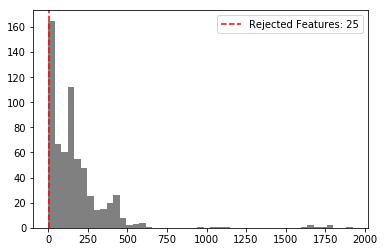

In [27]:
print 'Calculate Effect size for: %s' %table

calculate_Effect_size(table)